Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
PRINT = False
SAVE = False

In [2]:
net_type = 'ResNet'
photo_name = 'montage'
out_PSNR_name = 'data/testdata/denoising/other/' + photo_name + '_PSNR_' + net_type + '.txt'
out_img_name = 'data/testdata/denoising/montage/' + net_type + '.png'

if photo_name == 'boat' or photo_name == 'montage':
    SAVE = True

In [3]:
sigma = 25
sigma_ = sigma/255.
fname = 'data/testdata/denoising/' + photo_name + '.png'

# Load image

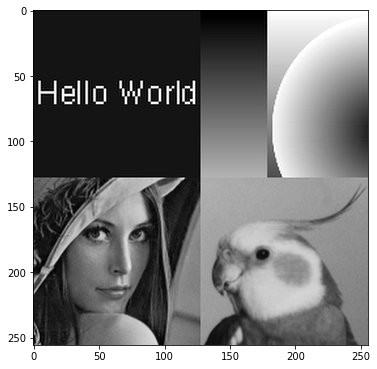

In [4]:
img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_noisy_np = pil_to_np(img_noisy_pil)

# As we don't have ground truth
img_pil = img_noisy_pil
img_np = img_noisy_np

if PLOT:
    plot_image_grid([img_np], 4, 5)

# Setup

In [5]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
print_every = 10
exp_weight=0.99

num_iter = 3000
input_depth = 32 
figsize = 4 

net = get_net(net_type, input_depth, 1).type(dtype)

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 167329


# Optimize

In [6]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

progress_ckp = [0, 100, 200, 500, 1000, 2000, 3000]
dn_img_history = []

In [7]:
i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, out_PSNR_name
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
    # print to file
    if PRINT and i % print_every == 0:
        with open(out_PSNR_name,'a') as f:
            f.write('%5d %f %f\n'%(i, psrn_gt, psrn_gt_sm))
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    if i in progress_ckp:
        dn_img_history.append(np.clip(out_np, 0, 1))
            
    i += 1

    return total_loss

Starting optimization with ADAM


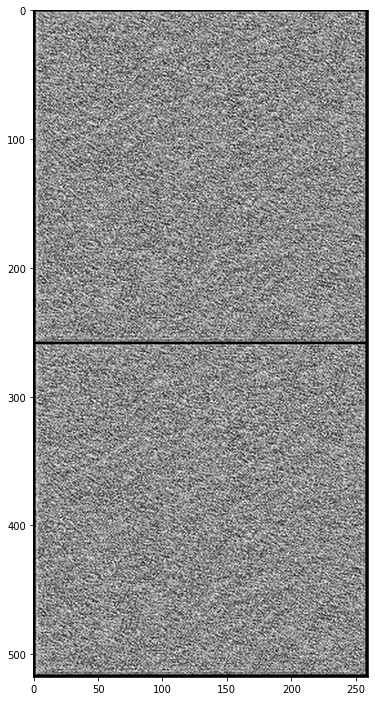

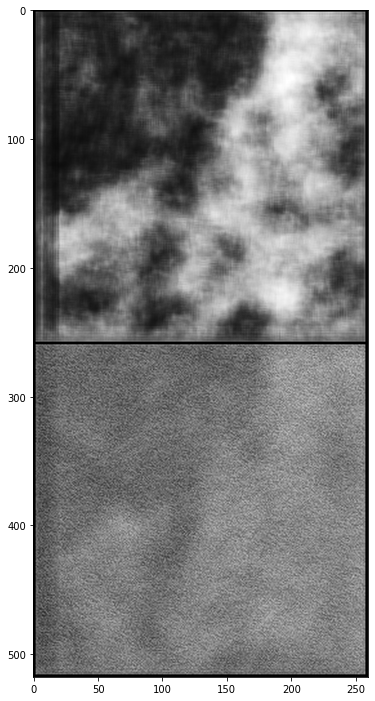

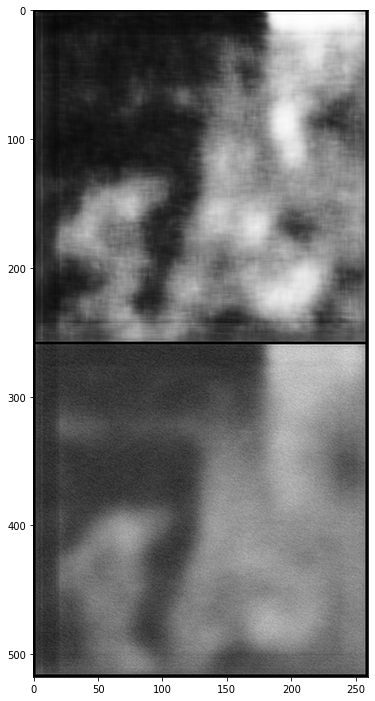

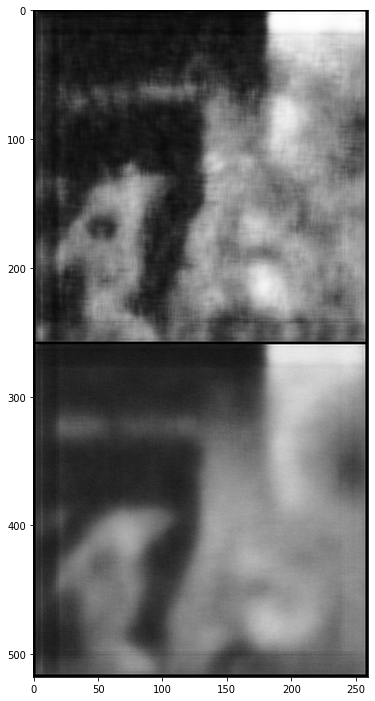

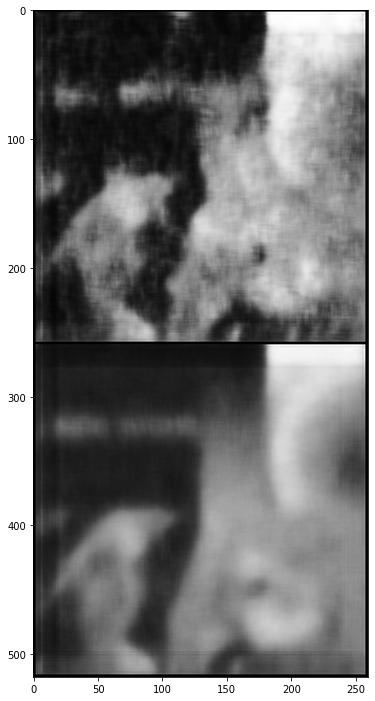

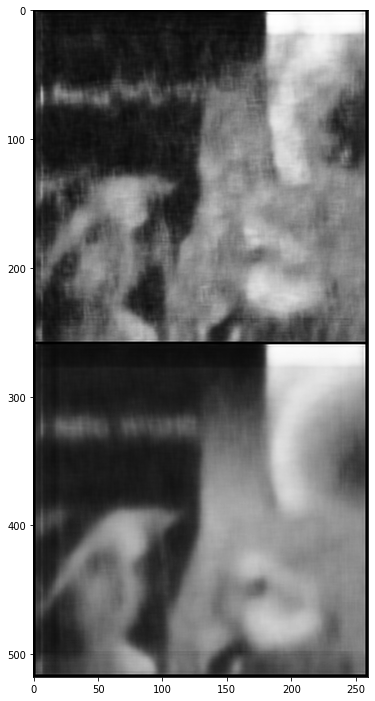

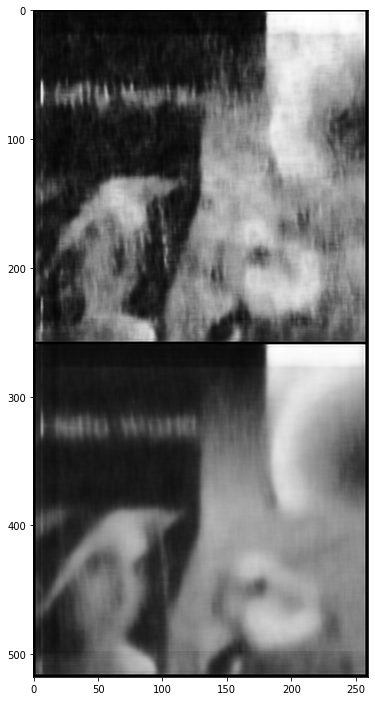

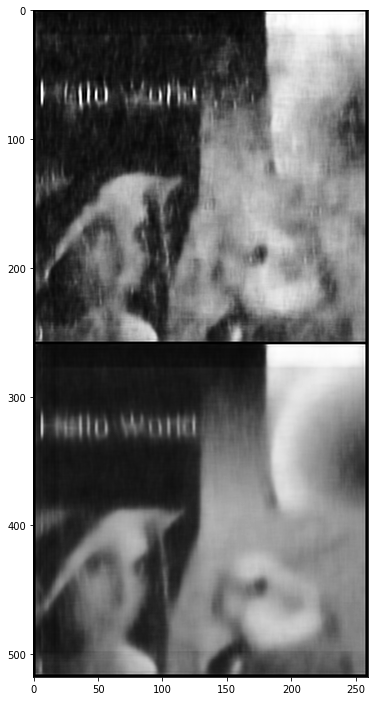

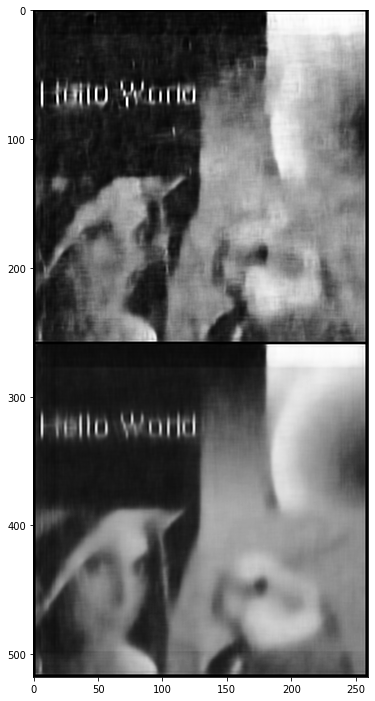

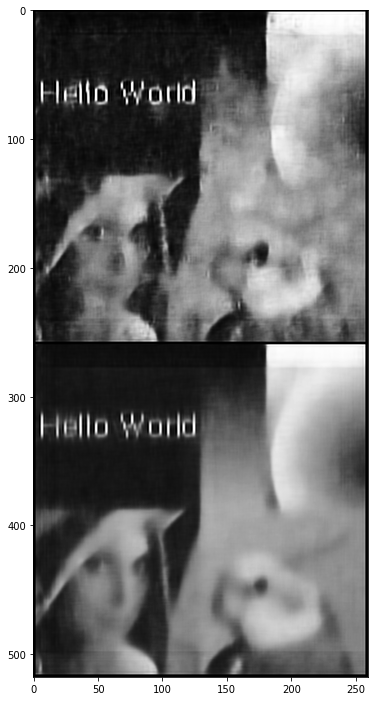

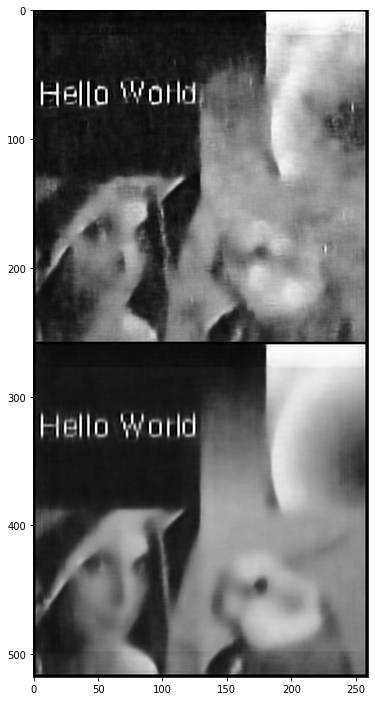

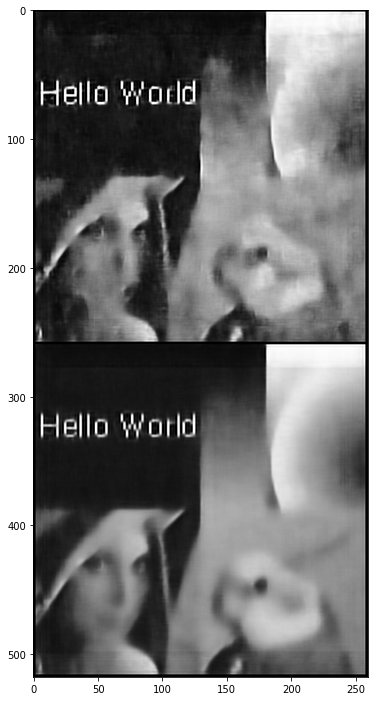

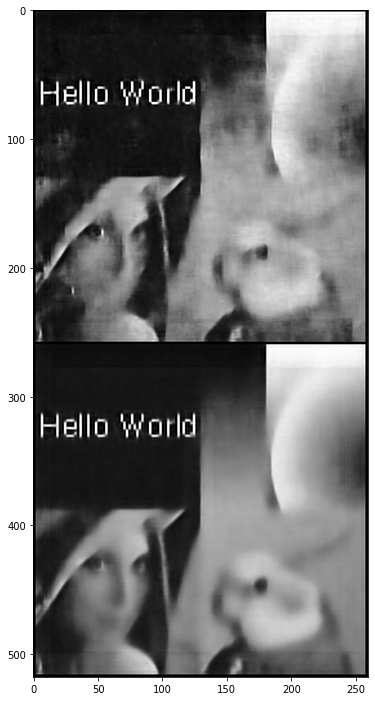

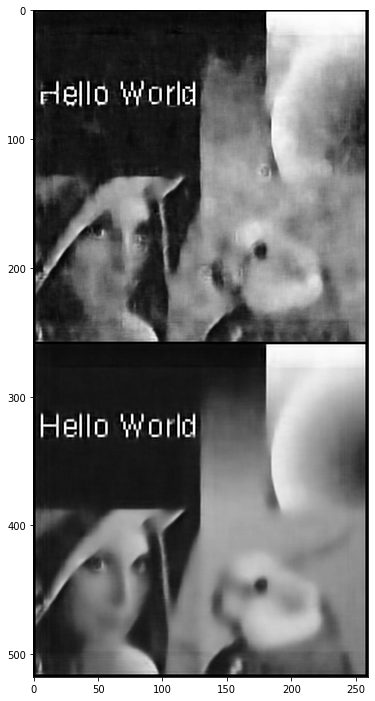

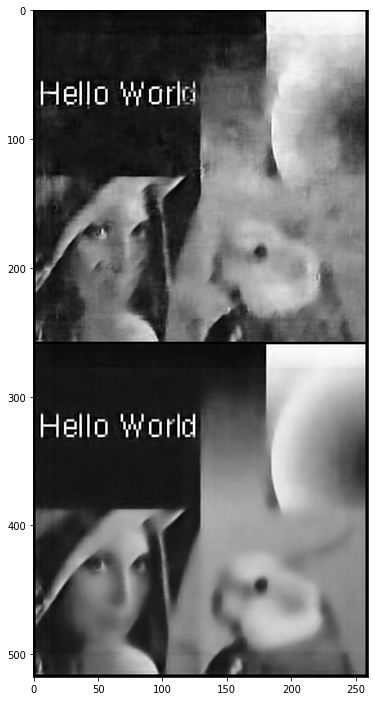

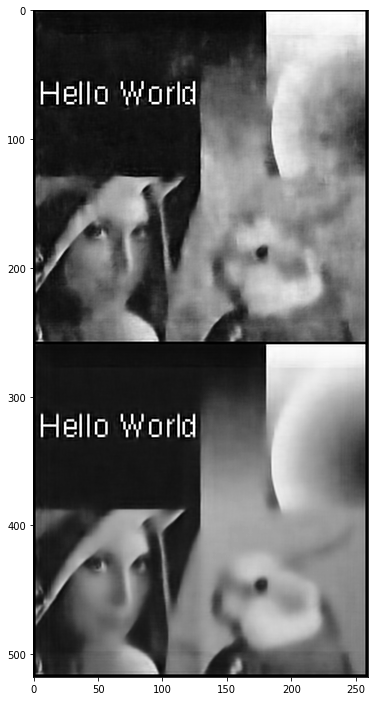

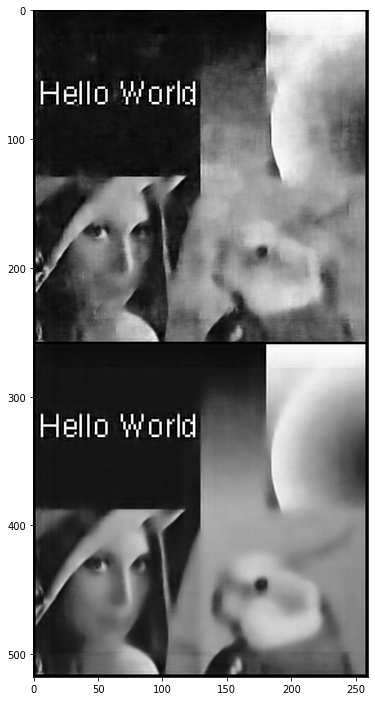

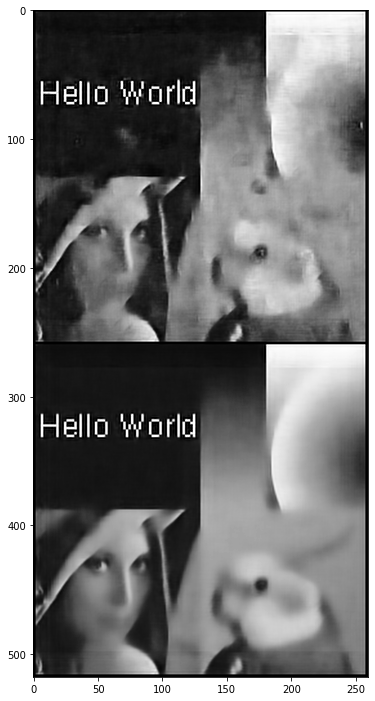

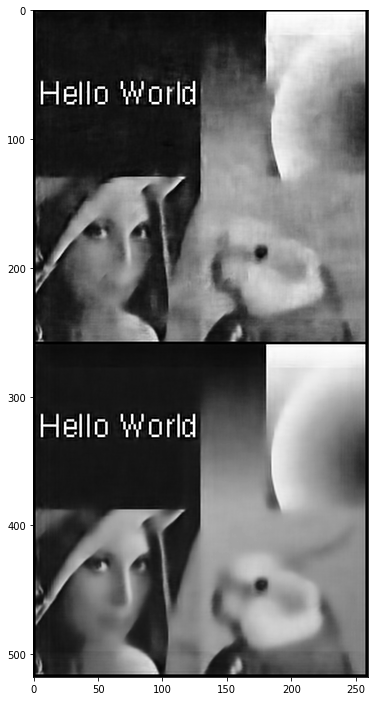

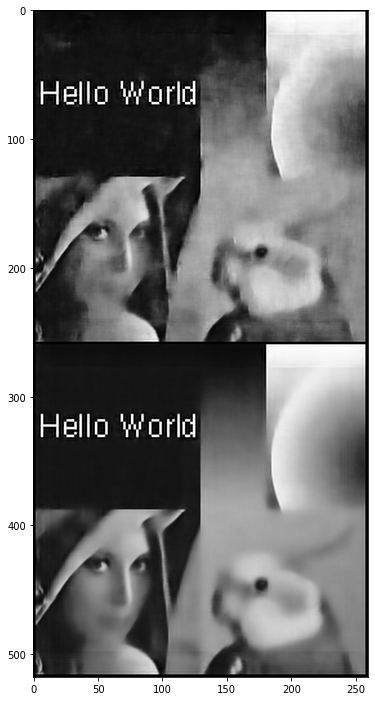

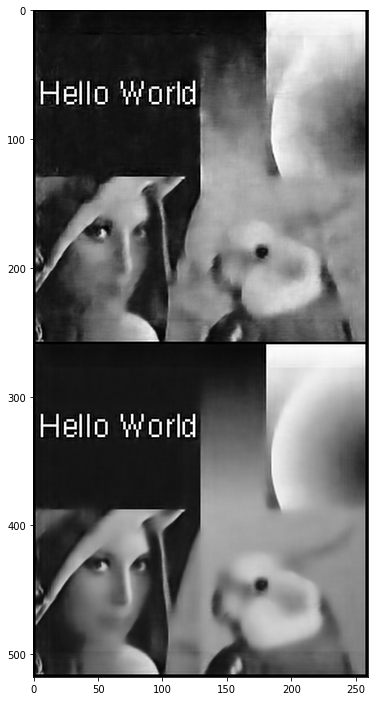

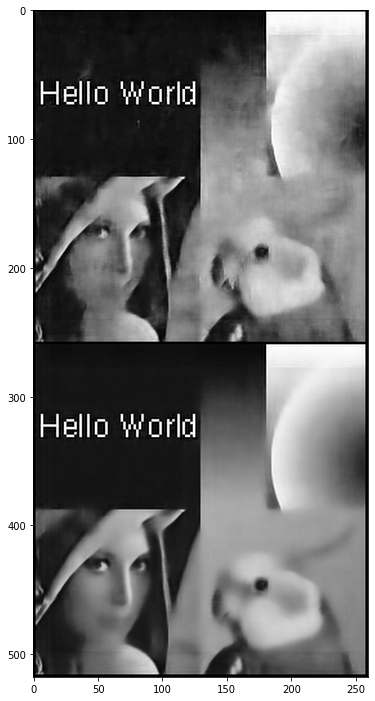

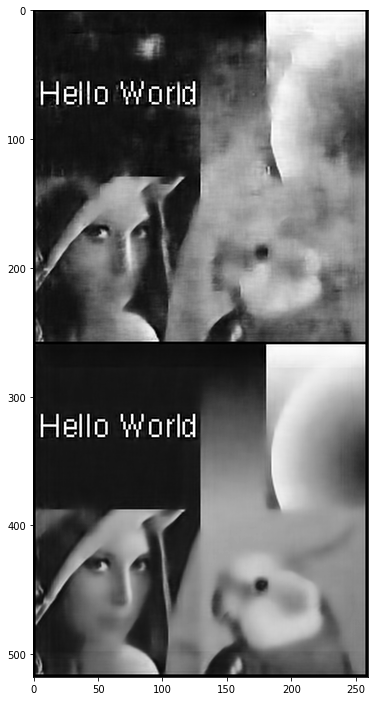

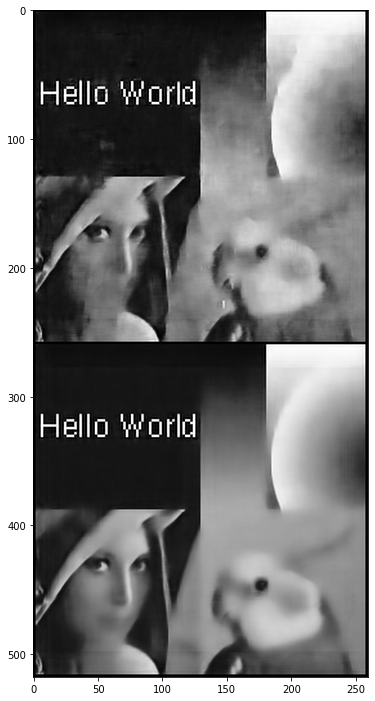

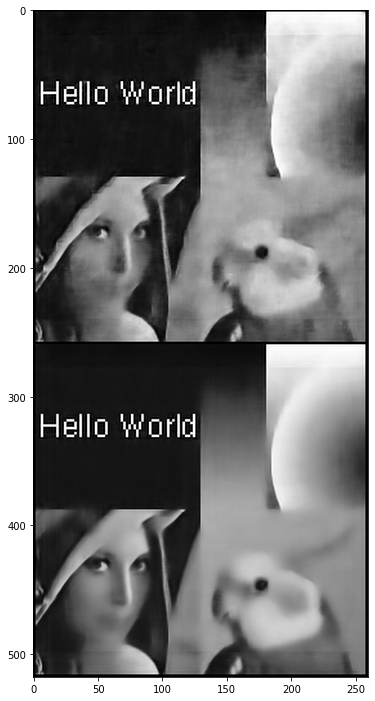

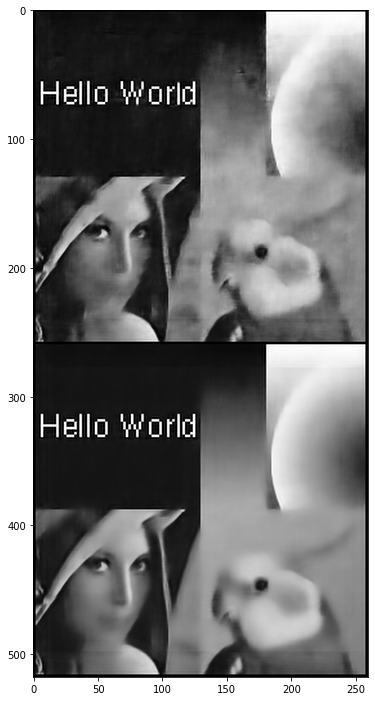

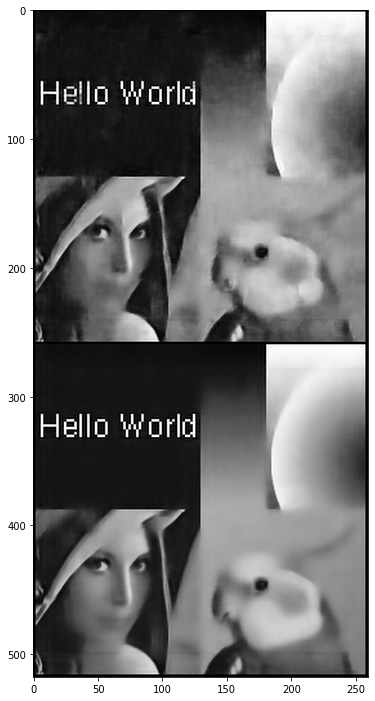

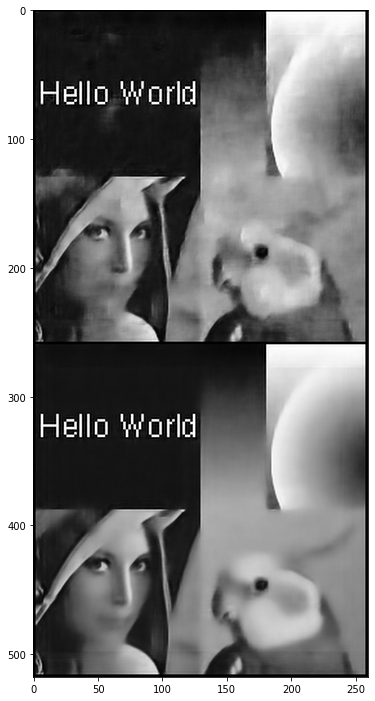

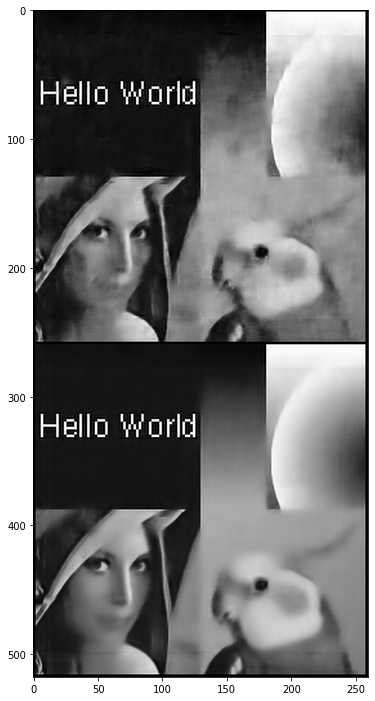

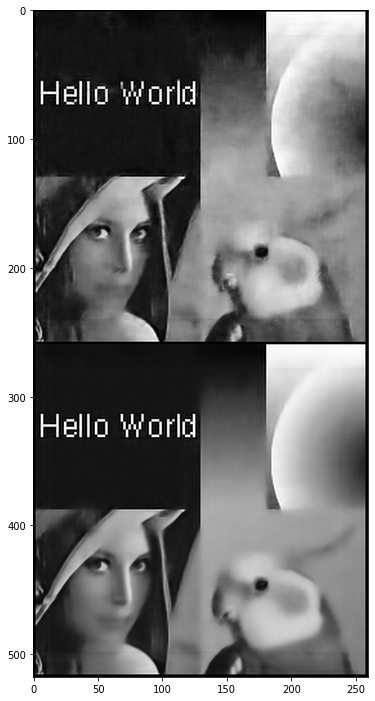

In [8]:
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

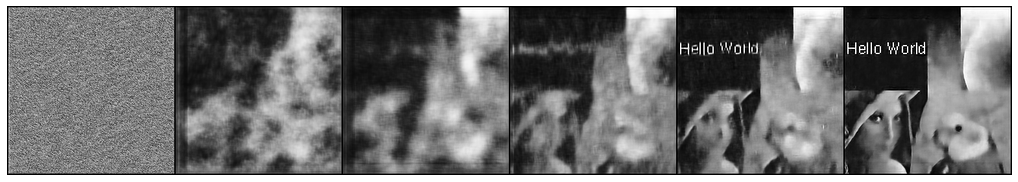

In [9]:
if SAVE:
    save_image_grid(out_img_name, dn_img_history, 7, 12)